# Profiles of supergranule flow and vector potential

In [17]:
from __future__ import division
%load_ext Cython
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pyfits
import plotc
import read_params
np.set_printoptions(precision=3)
import scipy.integrate
import dbyd2
import matplotlib.ticker
import scipy.fftpack
from scipy.special import j1,j0,jn
from scipy import interpolate

def j2(x): return jn(2,x)

def fitsread(f): return np.squeeze(pyfits.getdata(f)).byteswap().newbyteorder()

Lx=read_params.get_xlength()
nx=read_params.get_nx()
x=np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
z=np.loadtxt(read_params.get_solarmodel(),usecols=[0])
Rsun = 6.95989467700E2
z=(z-1)*Rsun

c,rho = np.loadtxt(read_params.get_solarmodel(),usecols=[1,2],unpack=True)
c.shape += (1,)
rho.shape += (1,)
c/=100 # convert to m/s

r_modelS,c_modelS,rho_modelS = np.loadtxt('modelS.txt',usecols=[0,1,2],comments="#",unpack=True)
r_modelS=r_modelS[np.where(r_modelS>0.8)]
rho_modelS=rho_modelS[np.where(r_modelS>0.8)]
c_modelS=c_modelS[np.where(r_modelS>0.8)]
r_modelS=r_modelS[::-2]
rho_modelS=rho_modelS[::-2]
c_modelS=c_modelS[::-2]
z_modelS = (r_modelS-1)*Rsun

c_modelS.shape += (1,)
rho_modelS.shape += (1,)
c_modelS/=100 # Convert to m/s

def ind_x(x): return int((x/Lx+1/2)*nx)
def ind_z(z_coord): return abs(z-z_coord).argmin()

z_surf=ind_z(0)

dbyd2_z = np.zeros((1,)+z.shape,order='F')
dbyd2.dbyd2(dbyd2_z,np.asfortranarray(np.atleast_2d(z)),1)

def ddz(arr):
    arr = np.asfortranarray(arr).T
    numerator = np.zeros(arr.shape,order='F')
    dbyd2.dbyd2(numerator,arr,1)
    return (numerator/dbyd2_z).T

dbyd2_z_S = np.zeros((1,)+z_modelS.shape,order='F')
dbyd2.dbyd2(dbyd2_z_S,np.asfortranarray(np.atleast_2d(z_modelS)),1)

def ddzS(arr):
    arr = np.asfortranarray(arr).T
    numerator = np.zeros(arr.shape,order='F')
    dbyd2.dbyd2(numerator,arr,1)
    return (numerator/dbyd2_z_S).T

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [2]:
%%cython
import numpy as np
cimport numpy as np
import scipy.fftpack
import read_params

Lx = read_params.get_xlength()

cpdef ddx(arr):
    cdef np.ndarray[np.float64_t,ndim=2] darr = np.empty_like(arr)
    cdef int nz = arr.shape[0]
    cdef int nx = arr.shape[1]
    cdef int k
    
    for k in xrange(nz):
        darr[k] = scipy.fftpack.diff(arr[k],period=Lx)
        
    return darr

## Fourier smoothing

In [3]:
def fourier_smoothing(arr,nk):
    arr_fft = np.fft.fft(arr,axis=1)
    k = np.fft.fftfreq(nx,1./nx)
    sigmak = nk # Factor of 2*pi/Lx cancels out in numerator and denominator 
    smoothing_fn = np.exp(-k**2/(2*sigmak**2))
    
    arr_fft*=smoothing_fn
    
    return np.fft.ifft(arr_fft,axis=1).real

## Analytical expressions for velocity

Following Duvall and Hanasoge (2013)

In [13]:
v0 = 240 #ms^−1
k = 2*np.pi/30 #rad Mm^−1
kay=2*np.pi/(30/Rsun)
dimc=1e6 # cm/s
R = 15 #Mm, 
z0 = -2.3 #Mm 
sigmaz = 0.912 #Mm
rand2= v0*100./dimc/ kay

We define 
$$
u\left(z\right) = \frac{v_{0}}{k}e^{-\left(z-z_{0}\right)^{2}/2\sigma_{z}^{2}}
$$

The velocity components are defined as

$$
\begin{eqnarray*}
v_{x} & = & v_{0}\mathrm{\,sign}\left(x\right)\frac{1}{k}\,J_{1}\left(k\left|x\right|\right)\left(\frac{\left(z-z_{0}\right)}{\sigma_{z}^{2}}-\frac{d\ln\rho}{dz}\right)\exp\left(-\frac{\left(z-z_{0}\right)^{2}}{2\sigma_{z}^{2}}-\frac{\left|x\right|}{R}\right)\\
 & = & \mathrm{sign}\left(x\right)\,u\left(z\right)\left(\frac{\left(z-z_{0}\right)}{\sigma_{z}^{2}}-\frac{d\ln\rho}{dz}\right)J_{1}\left(k\left|x\right|\right)\exp\left(-\frac{\left|x\right|}{R}\right)\\
v_{z} & = & v_{0}\frac{1}{2}\left(J_{0}\left(k\left|x\right|\right)-J_{2}\left(k\left|x\right|\right)-\frac{2}{kR}J_{1}\left(k\left|x\right|\right)\right)\exp\left(-\frac{\left(z-z_{0}\right)^{2}}{2\sigma_{z}^{2}}-\frac{\left|x\right|}{R}\right)\\
 & = & ku\left(z\right)\frac{1}{2}\left(J_{0}\left(k\left|x\right|\right)-J_{2}\left(k\left|x\right|\right)-\frac{2}{kR}J_{1}\left(k\left|x\right|\right)\right)\exp\left(-\frac{\left|x\right|}{R}\right).
\end{eqnarray*}
$$

In [5]:
u = v0/k*np.exp(-(z-z0)**2/(2*sigmaz**2))
u = u[:,np.newaxis]

# vx
zderiv = (z[:,None]-z0)/sigmaz**2 - ddz(np.log(rho))
xpart = j1(k*abs(x))*exp(-abs(x)/R)*np.sign(x)
xpart = xpart[np.newaxis,:]

vx_duvhan = u*zderiv*xpart
print "vx max",round(vx_duvhan.max(),2)
print "vx max at surface",round(vx_duvhan[ind_z(0)].max(),2)

print
# vz
xpart = 0.5*(j0(k*abs(x))-j2(k*abs(x))-2/(k*R)*j1(k*abs(x)))*exp(-abs(x)/R)
xpart = xpart[np.newaxis,:]
vz_duvhan = k*u*xpart
print "vx max",round(vz_duvhan[ind_z(z0)].max(),2)
print "vz max at surface",round(vz_duvhan[ind_z(0)].max(),2)

vx max 595.4
vx max at surface 233.52

vx max 119.91
vz max at surface 5.09


## Numerical velocity from analytical potential

The potential is defined as

$$
\begin{eqnarray*}
\psi^{\mathrm{ref}} & = & \frac{v_{0}}{c\left(z\right)}\frac{\mathrm{sign}\left(x\right)}{k}\,J_{1}\left(k\left|x\right|\right)\exp\left(-\frac{\left(z-z_{0}\right)^{2}}{2\sigma_{z}^{2}}-\frac{\left|x\right|}{R}\right)\\
 & = & \frac{u\left(z\right)}{c\left(z\right)}\mathrm{sign}\left(x\right)\,J_{1}\left(k\left|x\right|\right)\exp\left(-\frac{\left|x\right|}{R}\right),
\end{eqnarray*}
$$

vx max : 595.4
vx surface max : 236.5

vz max : 116.78
vz surface max : 4.96

vx ratio, max 0.97
vx ratio, surface 0.97

Difference in psi 4.97865637605e-16


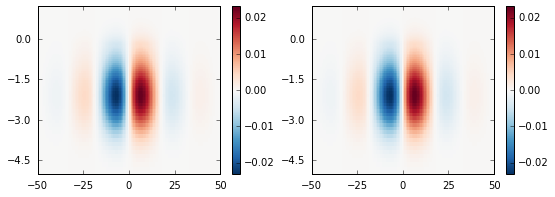

In [23]:
xpart = j1(k*abs(x))*exp(-abs(x)/R)*np.sign(x)
xpart = xpart[np.newaxis,:]
c_psi_duvhan = u*xpart
psi_duvhan = c_psi_duvhan/c

vx_from_psi_duvhan = -ddz(rho*c_psi_duvhan)/rho
print "vx max :",round(vx_from_psi_duvhan.max(),2)
print "vx surface max :",round(vx_from_psi_duvhan[ind_z(0)].max(),2)

print

vz_from_psi_duvhan = ddx(c_psi_duvhan)
print "vz max :",round(vz_from_psi_duvhan[ind_z(z0)].max(),2)
print "vz surface max :",round(vz_from_psi_duvhan[ind_z(0)].max(),2)

print
print "vx ratio, max",round(vz_from_psi_duvhan[ind_z(z0)].max()/vz_duvhan[ind_z(z0)].max(),2)
print "vx ratio, surface",round(vz_from_psi_duvhan[ind_z(0)].max()/vz_duvhan[ind_z(0)].max(),2)

gl=plotc.gridlist(1,2)
true_psi_sparc = fitsread('true_psi.fits')
plotc.colorplot(psi_duvhan,x=x,y=z,xr=[-50,50],yr=[-5,None],sp=next(gl));
plotc.colorplot(true_psi_sparc,x=x,y=z,xr=[-50,50],yr=[-5,None],sp=next(gl));
plt.gcf().set_size_inches(9,3);
print
print "Difference in psi",abs(psi_duvhan - true_psi_sparc).max()

In [24]:
(ddz(rho*c*true_psi_sparc)/rho).max()

595.39933151061086

## Potential smoothed along x

In [202]:
c_psi_duvhan_smoothed_x = fourier_smoothing(c_psi_duvhan,90)
vx_from_psi_duvhan_smoothed_x = -ddz(rho*c_psi_duvhan_smoothed_x)/rho
vz_from_psi_duvhan_smoothed_x = ddx(c_psi_duvhan_smoothed_x)

print "vx max :",round(vx_from_psi_duvhan_smoothed_x.max(),2)
print "vx surface max :",round(vx_from_psi_duvhan_smoothed_x[ind_z(0)].max(),2)

print

print "vz max :",round(vz_from_psi_duvhan_smoothed_x[ind_z(z0)].max(),2)
print "vz surface max :",round(vz_from_psi_duvhan_smoothed_x[ind_z(0)].max(),2)

vx max : 570.37
vx surface max : 226.56

vz max : 100.03
vz surface max : 4.25


## Potential smoothed along z

### Plots of density and derivatives

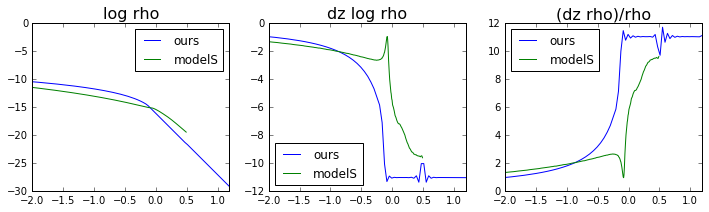

In [81]:
gl = plotc.gridlist(1,3)
z_cut = -2

plt.subplot(next(gl))
plt.plot(z,np.log(rho),label="ours");
plt.plot(z_modelS,np.log(rho_modelS),label="modelS");
plt.xlim(z_cut,z[-1]);
plt.legend(loc="best");
plt.title("log rho",fontsize=16)

plt.subplot(next(gl))
plt.plot(z,ddz(np.log(rho)),label="ours");
plt.plot(z_modelS,ddzS(np.log(rho_modelS)),label="modelS");
plt.xlim(z_cut,z[-1]);
plt.legend(loc="best");
plt.title("dz log rho",fontsize=16);

plt.subplot(next(gl));
plt.plot(z,-ddz(rho)/rho,label="ours");
plt.plot(z_modelS,-ddzS(rho_modelS)/rho_modelS,label="modelS");
plt.xlim(z_cut,z[-1]);
plt.legend(loc="best");
plt.title("(dz rho)/rho",fontsize=16);

plt.gcf().set_size_inches(12,3);

## Smoothing spline

We can define the horizontal component of velocity as 

$$
\begin{eqnarray*}
v_{x} & = & -\frac{1}{\rho}\partial_{z}\left(\rho c\psi\right)\\
 & = & -\left(\partial_{z}\ln\rho\right)c\psi-\partial_{z}\left(c\psi\right)\\
\rho v_{x} & = & -\partial_{z}\left(\rho c\psi\right)\\
 & = & -\left(\partial_{z}\rho\right)c\psi-\rho\partial_{z}\left(c\psi\right)
\end{eqnarray*}
$$

vx max : 528.64
vx surface max : 234.61


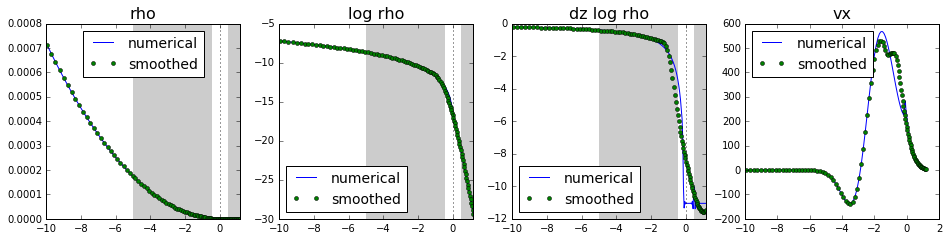

In [262]:
# smooth log rho

left_1=-5
right_1=-0.5
left_2=0.5
right_2=z[-1]
left_large = -10

def pick_lr(arr):
    arr = arr.flatten()
    left = arr[(z>left_1) & (z<right_1)]
    right = arr[(z>left_2) & (z<right_2)]
    return np.concatenate((left,right))

dzlogrho = ddz(np.log(rho))
logrho_smooth_spline_surface = interpolate.UnivariateSpline(pick_lr(z),pick_lr(np.log(rho)),s=0.5)
dzlogrho_smooth_spline_surface = logrho_smooth_spline_surface.derivative()

dzlogrho_smoothed=np.concatenate((dzlogrho.flatten()[z<left_1],
                                  dzlogrho_smooth_spline_surface(z[(z>=left_1) & (z<=right_2)]),
                                 dzlogrho.flatten()[z>right_2]))
dzlogrho_smoothed = dzlogrho_smoothed[:,np.newaxis]

logrho_smoothed=np.concatenate((np.log(rho).flatten()[z<left_1],
                                logrho_smooth_spline_surface(z[(z>=left_1) & (z<=right_2)]),
                               np.log(rho).flatten()[z>right_2]))
logrho_smoothed = logrho_smoothed[:,np.newaxis]

rho_smoothed = np.exp(logrho_smoothed)
dzrho_smoothed = dzlogrho_smoothed*rho_smoothed

gl = plotc.gridlist(1,4)

plt.subplot(next(gl))
plt.plot(z[z>left_large],rho[z>left_large],label="numerical");
plt.plot(z[z>left_large],rho_smoothed[z>left_large],'o',label="smoothed",ms=4);
plt.gca().axvline(0,ls="dotted",color="k",alpha=0.8)
plt.xlim(left_large,z[-1]);
plt.legend(loc="best",fontsize=14)
plt.title("rho",fontsize=16)
plt.gca().axvspan(left_1,right_1,color='0.8')
plt.gca().axvspan(left_2,right_2,color='0.8')

plt.subplot(next(gl))
plt.plot(z[z>left_large],np.log(rho[z>left_large]),label="numerical");
plt.plot(z[z>left_large],logrho_smoothed[z>left_large],'o',label="smoothed",ms=4);
plt.gca().axvline(0,ls="dotted",color="k",alpha=0.8)
plt.xlim(left_large,z[-1]);
plt.legend(loc="best",fontsize=14)
plt.title("log rho",fontsize=16)
plt.gca().axvspan(left_1,right_1,color='0.8')
plt.gca().axvspan(left_2,right_2,color='0.8')

plt.subplot(next(gl))
plt.plot(z[z>left_large],dzlogrho[z>left_large],label="numerical");
plt.plot(z[z>left_large],dzlogrho_smoothed[z>left_large],'o',label="smoothed",ms=4);
plt.gca().axvline(0,ls="dotted",color="k",alpha=0.8)
plt.gca().axvspan(left_1,right_1,color='0.8')
plt.gca().axvspan(left_2,right_2,color='0.8')

plt.xlim(left_large,z[-1]);
plt.legend(loc="best",fontsize=14)
plt.title("dz log rho",fontsize=16)

# vx, with and without smoothing
plt.subplot(next(gl))
vmax = vx_from_psi_duvhan.max()
vx_from_psi_duvhan_smoothed_xz = (-dzlogrho_smoothed*c_psi_duvhan_smoothed_x
                                 -ddz(c_psi_duvhan_smoothed_x))

plt.plot(z[z>left_large],vx_from_psi_duvhan_smoothed_x[z>left_large,ind_x(8)],label="numerical")
plt.plot(z[z>left_large],vx_from_psi_duvhan_smoothed_xz[z>left_large,ind_x(8)],'o',label="smoothed",ms=4)
plt.title("vx",fontsize=16)
plt.legend(loc="best",fontsize=14)

plt.gcf().set_size_inches(16,3.5)

print "vx max :",round(vx_from_psi_duvhan_smoothed_z.max(),2)
print "vx surface max :",round(vx_from_psi_duvhan_smoothed_z[ind_z(0)].max(),2)

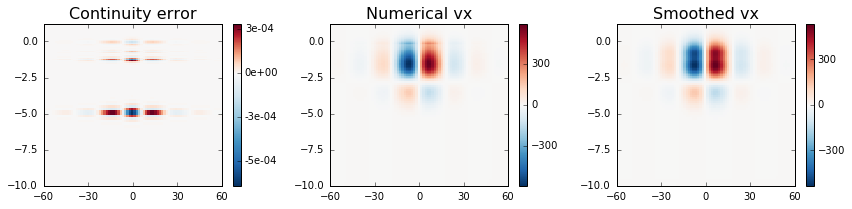

In [258]:
rho_vx_smoothed = rho_smoothed*vx_from_psi_duvhan_smoothed_xz
rho_vz_smoothed = rho_smoothed*vz_from_psi_duvhan_smoothed_x
cont = ddx(rho_vx_smoothed) + ddz(rho_vz_smoothed)
cont = cont/(dzrho_smoothed*c)
plotc.colorplot(cont,sp=131,x=x,y=z,xr=[-60,60],yr=[left_large,None]);
plt.title("Continuity error",fontsize=16)
plotc.colorplot(vx_from_psi_duvhan,x=x,y=z,xr=[-60,60],yr=[left_large,None],sp=132);
plt.title("Numerical vx",fontsize=16)
plotc.colorplot(vx_from_psi_duvhan_smoothed_xz,x=x,y=z,xr=[-60,60],yr=[left_large,None],sp=133);
plt.title("Smoothed vx",fontsize=16)
plt.gcf().set_size_inches(12,3)
plt.tight_layout()

## Smooth sound speed
This is not strictly necessary, but might be useful to avoid artefacts 

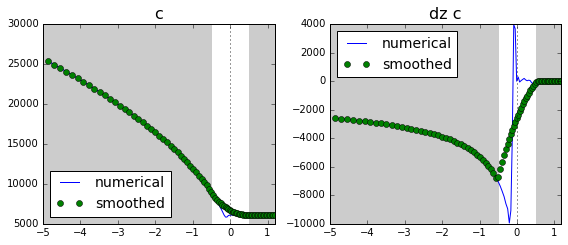

In [270]:
c_smooth_spline_surface = interpolate.UnivariateSpline(pick_lr(z),pick_lr(c),s=0.5)
dzc_smooth_spline_surface = c_smooth_spline_surface.derivative()
dzc = ddz(c)

dzc_smoothed=np.concatenate((dzc.flatten()[z<left_1],
                             dzc_smooth_spline_surface(z[(z>=left_1) & (z<=right_2)]),
                             dzc.flatten()[z>right_2]))
dzc_smoothed = dzc_smoothed[:,np.newaxis]

c_smoothed=np.concatenate((c.flatten()[z<left_1],
                           c_smooth_spline_surface(z[(z>=left_1) & (z<=right_2)]),
                          c.flatten()[z>right_2]))
c_smoothed = c_smoothed[:,np.newaxis]

gl = plotc.gridlist(1,2)

plt.subplot(next(gl))
plt.plot(z[z>left_1],c[z>left_1],label="numerical");
plt.plot(z[z>left_1],c_smoothed[z>left_1],'o',label="smoothed");
plt.gca().axvline(0,ls="dotted",color="k",alpha=0.8)
plt.xlim(left_1,z[-1]);
plt.legend(loc="best",fontsize=14)
plt.title("c",fontsize=16)
plt.gca().axvspan(left_1,right_1,color='0.8')
plt.gca().axvspan(left_2,right_2,color='0.8')

plt.subplot(next(gl))
plt.plot(z[z>left_1],dzc[z>left_1],label="numerical");
plt.plot(z[z>left_1],dzc_smoothed[z>left_1],'o',label="smoothed");
plt.gca().axvline(0,ls="dotted",color="k",alpha=0.8)
plt.gca().axvspan(left_1,right_1,color='0.8')
plt.gca().axvspan(left_2,right_2,color='0.8')

plt.xlim(left_1,z[-1]);
plt.legend(loc="best",fontsize=14)
plt.title("dz c",fontsize=16);

plt.gcf().set_size_inches(8,3.5);
plt.tight_layout();

## Save solar model with smoothed values

In [286]:
solar_model = np.loadtxt(read_params.get_solarmodel())
# Add columns at the end so that there is no backward compatibility issue
solar_model = np.hstack((solar_model,rho_smoothed,dzrho_smoothed,
                         logrho_smoothed,dzlogrho_smoothed,
                        c_smoothed*100,dzc_smoothed*100))
np.savetxt('solar_deep_smoothed',solar_model)

In [292]:
# save velocity and potential
psi_smoothed = c_psi_duvhan_smoothed_x/c_smoothed
def add_y(arr): return arr[:,np.newaxis,:]

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pyfits.writeto('true_psi_smoothed.fits',add_y(psi_smoothed),clobber=True)
    pyfits.writeto('true_vx_smoothed.fits',add_y(vx_from_psi_duvhan_smoothed_xz),clobber=True)
    pyfits.writeto('true_vz_smoothed.fits',add_y(vz_from_psi_duvhan_smoothed_x),clobber=True)

## Numerical continuity checks

## Continuity

In [116]:
def continuity(vx,vz):
    dz_rhovz = ddz(rho_smoothed*vz)
    dx_rhovx = ddx(rho_smoothed*vx)
    cont =  (dz_rhovz+dx_rhovx)/(dzrho_smoothed*c_smoothed)
    print "{:10.5E}".format(abs(cont).max())

### Load output from Fortran

In [287]:
true_vx_sparc = fitsread('true_vx.fits')
true_vz_sparc = fitsread('true_vz.fits')
true_psi_sparc = fitsread('true_psi.fits')

### Compare with smoothed potential

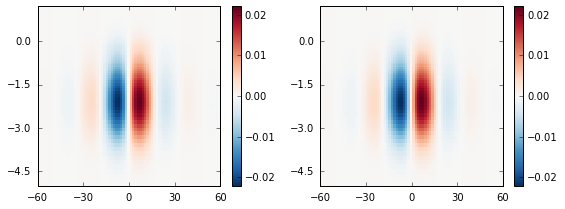

In [289]:
gl = plotc.gridlist(1,2)
plotc.colorplot(true_psi_sparc,x=x,y=z,xr=[-60,60],yr=[-5,None],sp=next(gl))
plotc.colorplot(c_psi_duvhan_smoothed_x/c_smoothed,x=x,y=z,xr=[-60,60],yr=[-5,None],sp=next(gl))
plt.gcf().set_size_inches(8,3)
plt.tight_layout()

### Analytical Expressions for velocity and vector potential
This is what the fortran code would compute without smoothing

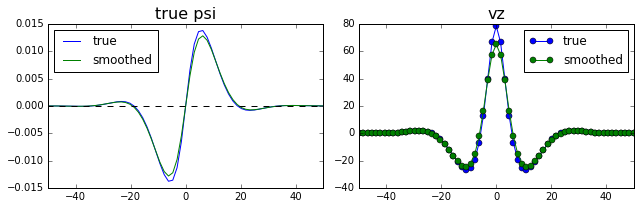

In [174]:
true_psi_smoothed=fourier_smoothing(true_psi_sparc,70)

gl=plotc.gridlist(1,2)
plt.subplot(next(gl));
plt.plot(x,true_psi_sparc[ind_z(-2.3)],label="true");
plt.plot(x,true_psi_smoothed[ind_z(-2.3)],label="smoothed");
plt.plot(x,np.zeros_like(x),'k--');
plt.xlim(-50,50)
plt.title("true psi",fontsize=16)
plt.legend(loc="best")

vz_from_smoothed_psi = fft_deriv_x(rho*c*true_psi_smoothed)/rho

plt.subplot(next(gl))
plt.plot(x,true_vz_sparc[ind_z(-2.3)],label="true",marker="o");
plt.plot(x,vz_from_smoothed_psi[ind_z(-2.3)],label="smoothed",marker="o");
plt.xlim(-50,50)
plt.legend(loc="best")
plt.title("vz",fontsize=16);

plt.gcf().set_size_inches(9,3)
plt.tight_layout()

In [175]:
vx_from_psi_dbyd2 = -1/rho*ddz(rho*c*true_psi_sparc)
vz_from_psi_fft = c*fft_deriv_x(true_psi_sparc) # move functions of z outside, rho cancels out

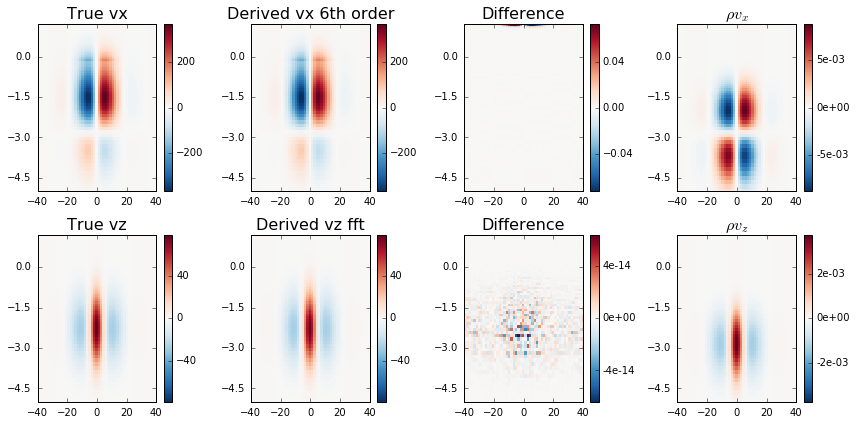

In [183]:
gl=plotc.gridlist(2,4)

plotc.colorplot(true_vx_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vx",fontsize=16)
plotc.colorplot(vx_from_psi_dbyd2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Derived vx 6th order",fontsize=16)
plotc.colorplot(true_vx_sparc-vx_from_psi_dbyd2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)
plotc.colorplot(rho*vx_from_psi_dbyd2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title(r"$\rho v_x$",fontsize=16)

plotc.colorplot(true_vz_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vz",fontsize=16)
plotc.colorplot(vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Derived vz fft",fontsize=16)
plotc.colorplot(true_vz_sparc-vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)
plotc.colorplot(rho*vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title(r"$\rho v_z$",fontsize=16)

plt.gcf().set_size_inches(12,6);
plt.tight_layout()

In [177]:
print "vz misft lower limit",np.sum((true_vz_sparc-vz_from_psi_fft)**2)/np.sum(true_vz_sparc**2)
print "vx misft lower limit",np.sum((true_vx_sparc-vx_from_psi_dbyd2)**2)/np.sum(true_vx_sparc**2)

vz misft lower limit 2.16323898839e-30
vx misft lower limit 2.42340184292e-09


## Vector potential from velocity

The vector potential that gives rise to these velocity fields can be computed in polar as well as Cartesian coordinates. The difference is that the vector potential is along $\mathbf{e}_\phi$ in polar and $\mathbf{e}_y$ in Cartesian. 

### Cartesian coordinates
 
 $$ \psi\left(x,z\right)=\frac{1}{\rho\left(z\right)c\left(z\right)}\int_{-L_x/2}^{x}dx^{\prime}\,\rho\left(z\right)v_{z}\left(x^{\prime},z\right).$$
 
or alternately in terms of $v_x$
 
 $$ \psi\left(x,z\right)=-\frac{1}{\rho\left(z\right)c\left(z\right)}\int_{z_{b}}^{z}dz^{\prime}\,\rho\left(z^{\prime}\right)v_{x}\left(x,z^{\prime}\right).$$
 
Let us do $v_z$ first

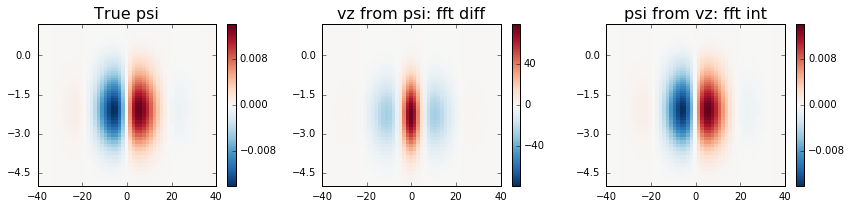

In [179]:
gl=plotc.gridlist(1,3)

plotc.colorplot(true_psi_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True psi",fontsize=16)

plotc.colorplot(vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("vz from psi: fft diff",fontsize=16)

psi_from_vz_from_psi = fft_int_x(rho*vz_from_psi_fft)/(rho*c)
plotc.colorplot(psi_from_vz_from_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("psi from vz: fft int",fontsize=16)

plt.gcf().set_size_inches(12,3)
plt.tight_layout()

psi_from_vz_from_psi=None

#### Let us try the same with $v_x$

In [115]:
psi_from_analytical_vx_trapz=-scipy.integrate.cumtrapz(rho*true_vx_sparc,x=z,axis=0,initial=0)/(rho*c)
psi_from_numerical_vx_trapz=-scipy.integrate.cumtrapz(rho*vx_from_psi_dbyd2,x=z,axis=0,initial=0)/(rho*c)
# psi_from_analytical_vx_spline=-spline_int_z(rho*true_vx_sparc)/(rho*c)
# psi_from_numerical_vx_spline=-spline_int_z(rho*vx_from_psi_dbyd2)/(rho*c)

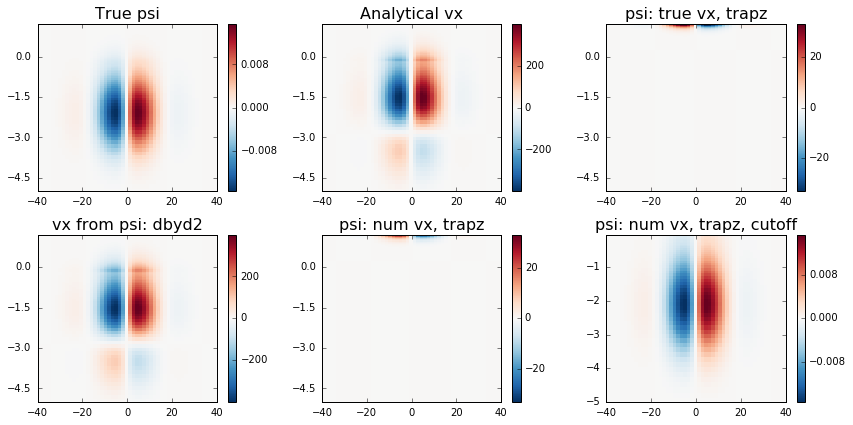

In [116]:
gl=plotc.gridlist(2,3)

plotc.colorplot(true_psi_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True psi",fontsize=16);

plotc.colorplot(true_vx_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Analytical vx",fontsize=16);

plotc.colorplot(psi_from_analytical_vx_trapz,x=x,y=z,xr=[-40,40],yr=[-5,None],
                centerzero=True,sp=next(gl));
plt.title("psi: true vx, trapz",fontsize=16);

plotc.colorplot(vx_from_psi_dbyd2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("vx from psi: dbyd2",fontsize=16);

plotc.colorplot(psi_from_numerical_vx_trapz,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("psi: num vx, trapz",fontsize=16);

upper_cutoff=ind_z(0)
plotc.colorplot(psi_from_numerical_vx_trapz[:upper_cutoff],x=x,y=z[:upper_cutoff],
                xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("psi: num vx, trapz, cutoff",fontsize=16);

# plotc.colorplot(psi_from_analytical_vx_spline,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
# plt.title("psi: true vx, spline",fontsize=16);

# plotc.colorplot(psi_from_numerical_vx_spline,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
# plt.title("psi: num vx, spline",fontsize=16);

plt.gcf().set_size_inches(12,6)
plt.tight_layout()

Inspecting $\rho v_x$

rho vx max 0.00539689230914
rho vx min -0.00503894363107


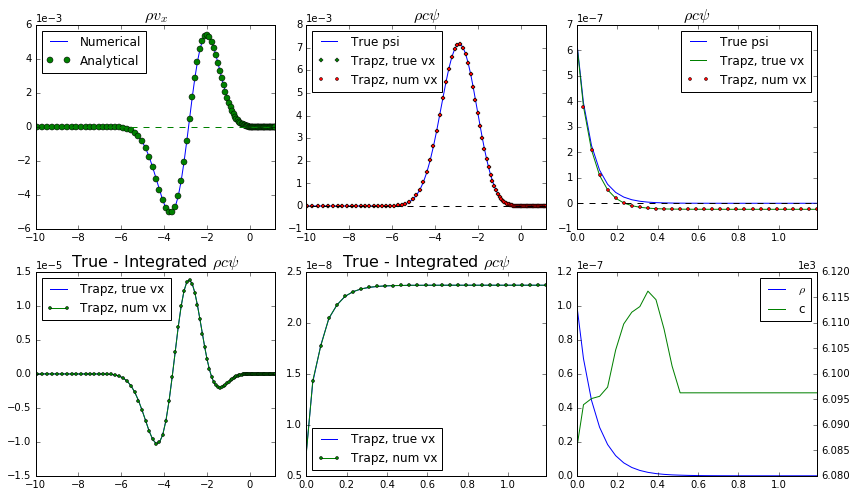

In [117]:
gl=plotc.gridlist(2,3)

x_cut_ind = ind_x(3) # Mm to pixel

plt.subplot(next(gl))
plt.plot(z,(rho*vx_from_psi_dbyd2)[:,x_cut_ind],label="Numerical");
plt.plot(z,(rho*true_vx_sparc)[:,x_cut_ind],'o',label="Analytical");
plt.plot(z,np.zeros_like(z),'g--');
plt.legend(loc="best")
plt.xlim(-10,z[-1]);
plt.title(r"$\rho v_x$",fontsize=16)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

print "rho vx max",(rho*vx_from_psi_dbyd2)[:,x_cut_ind].max()
print "rho vx min",(rho*vx_from_psi_dbyd2)[:,x_cut_ind].min()

plt.subplot(next(gl))
plt.plot(z,(rho*c*true_psi_sparc)[:,x_cut_ind],label="True psi");
plt.plot(z,(rho*c*psi_from_analytical_vx_trapz)[:,x_cut_ind],label="Trapz, true vx",
        marker="D",markersize=3,ls="None");
plt.plot(z,(rho*c*psi_from_numerical_vx_trapz)[:,x_cut_ind],label="Trapz, num vx",
         marker='o',markersize=3,ls="None");
plt.plot(z,np.zeros_like(z),color='k',ls="dashed")
plt.xlim(-10,z[-1]);
plt.title(r"$\rho c \psi$",fontsize=16)
plt.legend(loc="best")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

z_cutoff_ind=ind_z(0)
plt.subplot(next(gl))
plt.plot(z[z_cutoff_ind:],(rho*c*true_psi_sparc)[z_cutoff_ind:,x_cut_ind],label="True psi");
plt.plot(z[z_cutoff_ind:],(rho*c*psi_from_analytical_vx_trapz)[z_cutoff_ind:,x_cut_ind],label="Trapz, true vx");
plt.plot(z[z_cutoff_ind:],(rho*c*psi_from_numerical_vx_trapz)[z_cutoff_ind:,x_cut_ind],label="Trapz, num vx",
         marker='o',markersize=3,ls="None");
plt.xlim(0,z[-1]);
plt.plot(np.zeros_like(z),'k--');
plt.title(r"$\rho c \psi$",fontsize=16)
plt.legend(loc="best")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.subplot(next(gl))
plt.plot(z,(rho*c*(true_psi_sparc-psi_from_analytical_vx_trapz))[:,x_cut_ind],label="Trapz, true vx");
plt.plot(z,(rho*c*(true_psi_sparc-psi_from_numerical_vx_trapz))[:,x_cut_ind],label="Trapz, num vx",
        marker='o',markersize=3);
plt.xlim(-10,z[-1]);
plt.legend(loc="best")
plt.title(r"True - Integrated $\rho c \psi$",fontsize=16)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.subplot(next(gl))
plt.plot(z[z_cutoff_ind:],(rho*c*(true_psi_sparc-psi_from_analytical_vx_trapz))[z_cutoff_ind:,x_cut_ind],
         label="Trapz, true vx");
plt.plot(z[z_cutoff_ind:],(rho*c*(true_psi_sparc-psi_from_numerical_vx_trapz))[z_cutoff_ind:,x_cut_ind],
         label="Trapz, num vx",marker='o',markersize=3);
plt.xlim(0,z[-1]);
plt.legend(loc="best")
plt.title(r"True - Integrated $\rho c \psi$",fontsize=16)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

z_cutoff_ind=ind_z(0)
plt.subplot(next(gl))
l1=plt.plot(z[z_cutoff_ind:],rho.flatten()[z_cutoff_ind:],'b',label=r"$\rho$")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.gca().twinx()
l2=plt.plot(z[z_cutoff_ind:],c.flatten()[z_cutoff_ind:],'g',label="c")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.xlim(0,z[-1]);
lines=[l for l in l1+l2]
labels=[l.get_label() for l in lines]
plt.legend(lines,labels,loc="best")

plt.gcf().set_size_inches(12,7);
plt.tight_layout()

Integrating $v_x$ is a numerical problem

# Psi with cutoff

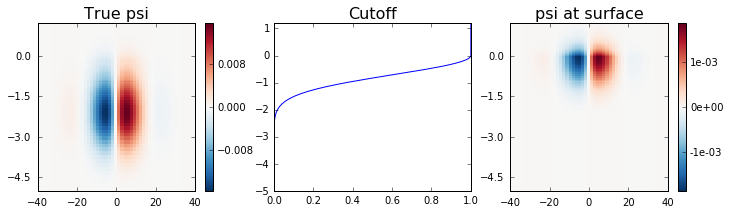

In [30]:
plotc.colorplot(true_psi_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=131);
plt.title("True psi",fontsize=16)

cutoff = z**2/1
cutoff[cutoff>100]=100
cutoff[z_surf:]=0.
cutoff = np.exp(-cutoff)
cutoff.shape += (1,)
psi_above_surface = true_psi_sparc.copy()
psi_above_surface[:z_surf] = np.tile(np.atleast_2d(psi_above_surface[z_surf]),(z_surf,1))
psi_above_surface*=cutoff

plt.subplot(132)
plt.plot(cutoff,z);
plt.ylim(-5,z[-1])
plt.title("Cutoff",fontsize=16)

plotc.colorplot(psi_above_surface,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=133);
plt.title("psi at surface",fontsize=16)

plt.gcf().set_size_inches(12,3)

Velocity corresponding to surface matched potential

In [31]:
vx_starting = -ddz(rho*c*psi_above_surface)/rho
vz_starting = fft_deriv_x(rho*c*psi_above_surface)/rho

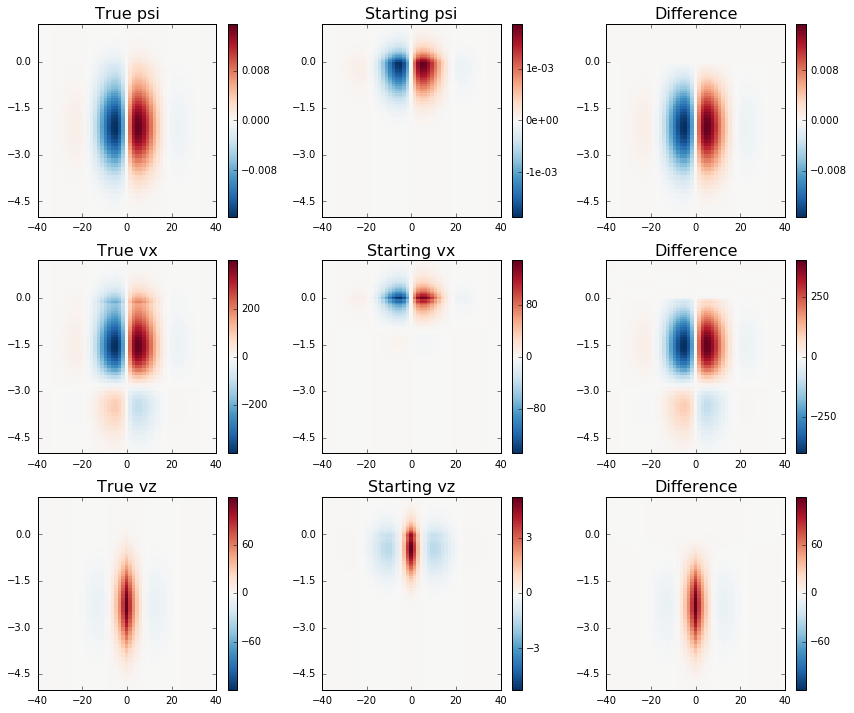

In [12]:
gl=plotc.gridlist(3,3)

plotc.colorplot(true_psi_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True psi",fontsize=16)

plotc.colorplot(psi_above_surface,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Starting psi",fontsize=16)

plotc.colorplot(true_psi_sparc-psi_above_surface,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plotc.colorplot(vx,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vx",fontsize=16)

plotc.colorplot(vx_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Starting vx",fontsize=16)

plotc.colorplot(vx-vx_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plotc.colorplot(vz,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vz",fontsize=16)

plotc.colorplot(vz_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Starting vz",fontsize=16)

plotc.colorplot(vz-vz_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plt.gcf().set_size_inches(12,10)
plt.tight_layout()

In [33]:
pyfits.writeto("model_psi_ls00.fits",psi_above_surface,clobber=True)
pyfits.writeto("vx_surface_constrained.fits",vx_starting,clobber=True)
pyfits.writeto("vz_surface_constrained.fits",vz_starting,clobber=True)